![](http://www.homecredit.net/~/media/Images/H/Home-Credit-Group/image-gallery/full/image-gallery-01-11-2016-b.png)

In [1]:
# Librairies personnalisées
from my_functions.common_functions import *
from my_functions.machine_learning_common_functions import *
from my_functions.dimensionality_reduction_functions import *
from my_functions.BorutaLGBM import BorutaPyForLGB
from BorutaShap import BorutaShap

from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from lightgbm import LGBMClassifier, early_stopping, Dataset, cv, plot_tree, plot_metric
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from sklearn.model_selection import StratifiedKFold
import shap

import gc
import re
import time
import pickle

import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()

# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

# # Supress unnecessary warnings so that presentation looks clean
# import warnings
# warnings.filterwarnings("ignore")

# Scoring Model

In [2]:
path_data = './Projet+Mise+en+prod+-+home-credit-default-risk/'

In [ ]:
df = pd.read_csv(path_data+'data.csv')

Le data set contient :
	- 307505 lignes et 723 colonnes.
	- 0 valeurs manquantes, ce qui représente 0.0 % du data set.


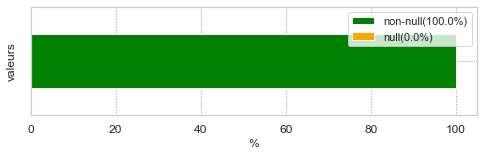

Voici un sous-échantillon aléatoire :


TARGET  GENDER  OWN_CAR  OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
5542       0.0     1.0      1.0         0.0           0.0          180000.0   
165988     0.0     1.0      1.0         0.0           0.0          243000.0   
53728      0.0     1.0      0.0         0.0           0.0           49500.0   
209240     0.0     1.0      0.0         0.0           0.0           99000.0   
19849      0.0     0.0      0.0         1.0           1.0          247500.0   
...        ...     ...      ...         ...           ...               ...   
21432      1.0     1.0      1.0         0.0           1.0          202500.0   
32445      0.0     1.0      0.0         0.0           0.0           76500.0   
131955     0.0     1.0      0.0         0.0           0.0          112500.0   
105138     0.0     1.0      0.0         0.0           0.0          900000.0   
22068      0.0     1.0      0.0         0.0           0.0           90000.0   

        AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
5542      835380.0      33259.5         675000.0                    0.007305   
165988    502497.0      33709.5         454500.0                    0.016617   
53728     675000.0      19476.0         675000.0                    0.026398   
209240   1260702.0      39582.0        1129500.0                    0.019104   
19849     733315.5      39199.5         679500.0                    0.019104   
...            ...          ...              ...                         ...   
21432     450000.0      32742.0         450000.0                    0.015221   
32445      98910.0       7164.0          90000.0                    0.010498   
131955    567000.0      30888.0         567000.0                    0.018204   
105138    463131.0      23773.5         346500.0                    0.010277   
22068     679500.0      19998.0         679500.0                    0.026398   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
5542      -12968.0        -3542.0            -4136.0          -5408.0   
165988    -19424.0        -4732.0            -1678.0          -2944.0   
53728     -21824.0        -2384.0           -11456.0          -4548.0   
209240    -19120.0        -3480.0            -1137.0          -2664.0   
19849     -10944.0         -334.0            -5276.0          -3456.0   
...            ...            ...                ...              ...   
21432     -11896.0         -691.0             -856.0           -657.0   
32445     -18368.0        -1202.0            -8536.0          -1599.0   
131955    -14696.0        -1481.0            -7176.0          -1219.0   
105138    -15800.0        -2336.0            -3154.0          -3168.0   
22068     -23040.0        -2384.0            -4380.0          -4376.0   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
5542           1.0             1.0              0.0               1.0   
165988         1.0             1.0              0.0               1.0   
53728          1.0             0.0              0.0               1.0   
209240         1.0             1.0              1.0               1.0   
19849          1.0             1.0              1.0               1.0   
...            ...             ...              ...               ...   
21432          1.0             1.0              0.0               1.0   
32445          1.0             1.0              1.0               1.0   
131955         1.0             1.0              0.0               1.0   
105138         1.0             1.0              0.0               1.0   
22068          1.0             0.0              0.0               1.0   

        FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
5542           1.0         0.0              2.0                   3.0   
165988         1.0         1.0              2.0                   2.0   
53728          1.0         0.0              2.0                   2.0   
209240         0.0         0.0              2.0     

In [4]:
verifier_taille(df)
afficher_echantillon(df, n=1000, frac=1.)

## Features Selection

In [5]:
x_train, x_test, y_train, y_test = trainning_sets(df, 'TARGET', train_size=0.8, scale='std')

### Boruta

In [ ]:
# define random forest classifier
model = LGBMClassifier(num_boost_round=100,
                        device_type='gpu',
                        scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),                            
                        random_state=0, verbose=-1, n_jobs=-1)

# define Boruta feature selection method
feat_selector = BorutaPyForLGB(model, n_estimators='auto', verbose=2, random_state=0)

# find all relevant features
feat_selector.fit(x_train, y_train)

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(x_train)

In [ ]:
# Important features
X= df.drop(columns=['TARGET'])
important = list(X.columns[feat_selector.support_])
print('>>>>', len(important), f"Features confirmed as important: {important}")# Tentative features
tentative = list(X.columns[feat_selector.support_weak_])
print('>>>>', len(tentative),f"Unconfirmed features (tentative): {tentative}")# Unimportant features
unimportant = list(X.columns[~(feat_selector.support_ | feat_selector.support_weak_)])
print('>>>>', len(unimportant),f"Features confirmed as unimportant: {unimportant}")

160 Features confirmed as important: ['GENDER', 'OWN_CAR', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_QRT', 'INCOME_TYPE_State_servant', 'INCOME_TYPE_Working', 'EDUCATION_TYPE_Higher_education', 'EDUCATION_TYPE_Secondary_secondary_special', 'FAMILY_STATUS_Married', 'OCCUPATION_TYPE_Core_staff', 'OCCUPATION_TYPE_Drivers', 'ORGANIZATION_TYPE_Construction', 'ORGANIZATION_TYPE_Self_employed', 'WALLSMATERIAL_MODE_Panel', 'DOCUMENT_COUNT', 'NEW_DOC_KURT', 'EXT_SOURCES_PROD', 'EXT_SOURCES_MIN', 'EXT_SOURCES_MAX', 'EXT_SOURCES_MEAN', 'EXT_SOURCES_NANMEDIAN', 'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE', 'CREDI

In [ ]:
dfb = df.drop(columns=unimportant)
dfb.to_csv(path_data+'data-boruta.csv', index=False)

### Boruta-SHAP

In [5]:
x_train, x_test, y_train, y_test = trainning_sets(df, 'TARGET', train_size=0.9, scale='std')

In [6]:
model = LGBMClassifier(
                            device_type='gpu',
                            scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),                            
                            random_state=0, verbose=-1, n_jobs=-1)

selector = BorutaShap(model=model, importance_measure = 'shap', classification = True)
# Fits the selector
selector.fit(X = pd.DataFrame(x_train, columns=df.drop(columns='TARGET').columns), y = y_train, n_trials = 50, random_state=0, sample=False, normalize=False, verbose = True)
# n_trials -> number of iterations for Boruta algorithm
# sample -> samples the data so it goes faster

100%|██████████| 50/50 [2:36:07<00:00, 187.35s/it]  

87 attributes confirmed important: ['EXT_SOURCES_MAX', 'DEF_60_CNT_SOCIAL_CIRCLE', 'PREV_NAME_PRODUCT_TYPE_walk_in_MEAN', 'EXT_SOURCE_3', 'PREV_APP_CREDIT_PERC_MEAN', 'APPROVED_SIMPLE_INTERESTS_MEAN', 'APP_AMT_INCOME_TOTAL_12_AMT_ANNUITY_ratio', 'OWN_CAR', 'AMT_REQ_CREDIT_BUREAU_QRT', 'ACTIVE_DEBT_CREDIT_DIFF_MIN', 'EDUCATION_TYPE_Secondary_secondary_special', 'CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN', 'INCOME_TYPE_Working', 'INS_D365DPD_DIFF_MAX', 'APPROVED_AMT_ANNUITY_MEAN', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'PREV_APP_CREDIT_PERC_MIN', 'ACTIVE_BUREAU_CREDIT_ENDDATE_DIFF_MAX', 'INSTAL_AMT_PAYMENT_SUM', 'CREDIT_TO_GOODS_RATIO', 'CREDIT_TO_GOODS_RATIO_2', 'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED_PERC', 'BURO_BUREAU_CREDIT_FACT_DIFF_MAX', 'FLAG_DOCUMENT_3', 'REGION_POPULATION_RELATIVE', 'APPROVED_AMT_DOWN_PAYMENT_MAX', 'INSTAL_PAYMENT_RATIO_MEAN', 'AMT_GOODS_PRICE', 'APPROVED_AMT_ANNUITY_SUM', 'ACTIVE_BUREAU_CREDIT_DEBT_RATIO_MEAN', 'FAMILY_STATUS_Married', 'POS_CNT_INSTALMENT_FUTURE_MAX', 'REG_CITY_

In [7]:
# Display features to be removed
features_to_remove = selector.features_to_remove
print(features_to_remove)

['OWN_REALTY' 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'FLAG_MOBIL'
 'FLAG_EMP_PHONE' 'FLAG_WORK_PHONE' 'FLAG_CONT_MOBILE' 'FLAG_PHONE'
 'FLAG_EMAIL' 'CNT_FAM_MEMBERS' 'REGION_RATING_CLIENT'
 'HOUR_APPR_PROCESS_START' 'REG_REGION_NOT_LIVE_REGION'
 'REG_REGION_NOT_WORK_REGION' 'LIVE_REGION_NOT_WORK_REGION'
 'REG_CITY_NOT_WORK_CITY' 'LIVE_CITY_NOT_WORK_CITY'
 'OBS_30_CNT_SOCIAL_CIRCLE' 'DEF_30_CNT_SOCIAL_CIRCLE'
 'OBS_60_CNT_SOCIAL_CIRCLE' 'FLAG_DOCUMENT_2' 'FLAG_DOCUMENT_4'
 'FLAG_DOCUMENT_5' 'FLAG_DOCUMENT_6' 'FLAG_DOCUMENT_7' 'FLAG_DOCUMENT_8'
 'FLAG_DOCUMENT_9' 'FLAG_DOCUMENT_10' 'FLAG_DOCUMENT_11'
 'FLAG_DOCUMENT_12' 'FLAG_DOCUMENT_13' 'FLAG_DOCUMENT_14'
 'FLAG_DOCUMENT_15' 'FLAG_DOCUMENT_16' 'FLAG_DOCUMENT_17'
 'FLAG_DOCUMENT_18' 'FLAG_DOCUMENT_19' 'FLAG_DOCUMENT_20'
 'FLAG_DOCUMENT_21' 'AMT_REQ_CREDIT_BUREAU_HOUR'
 'AMT_REQ_CREDIT_BUREAU_DAY' 'AMT_REQ_CREDIT_BUREAU_WEEK'
 'AMT_REQ_CREDIT_BUREAU_MON' 'AMT_REQ_CREDIT_BUREAU_YEAR'
 'CONTRACT_TYPE_Cash_loans' 'CONTRACT_TYPE_Revolving_loans'


In [8]:
dfbs = df.drop(columns=features_to_remove)
dfbs.to_csv(path_data+'data-boruta-shap.csv', index=False)

## Models

In [3]:
df = pd.read_csv(path_data+'data-boruta-shap.csv')
# df = dfbs
x_train, x_test, y_train, y_test = trainning_sets(df, 'TARGET', scale='std')

In [4]:
# tsne_manifolded = ManifoldReduction(df.drop(columns=['TARGET']), manifold = TSNE(n_components=2, perplexity=100, init="random", random_state=0, learning_rate='auto', metric='minkowski'))

In [5]:
# DisplayManifold(tsne_manifolded, n_components=2, c=df['TARGET'], s=1)

In [6]:
def EvalDisplay(clf, metric):
    y_predict = clf.predict(x_test)
    print('Socre:', metric(y_test, y_predict))
    
    #ROC
    AUC(y_train, clf.predict(x_train))
    AUC(y_test, y_predict)

    # Confusion Matrix        
    cm = confusion_matrix(y_test, y_predict, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()

In [7]:
def saveModel(model, model_name='model'):
    ### Create a Pickle file using serialization 
    pickle_out = open(model_name+".pkl","wb")
    pickle.dump(model, pickle_out)
    pickle_out.close()

### Built-in Metric : AUC

In [8]:
def MyScore(y_test, y_pred):
  return roc_auc_score(y_test, y_pred)

#### Baseline

In [9]:
def baseline(scoring):
    return LogisticRegressionCV(cv=10, scoring=make_scorer(scoring), random_state=0, n_jobs=-1).fit(x_train, y_train)

Socre: 0.5100074281823621


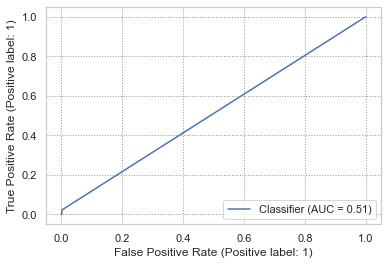

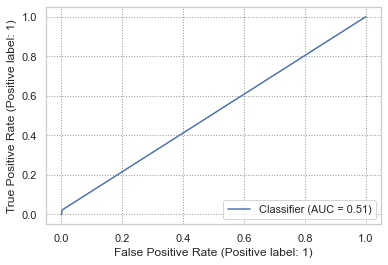

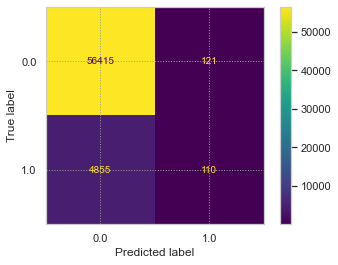

In [10]:
clf = baseline(MyScore)
EvalDisplay(clf, MyScore)
saveModel(clf, 'baseline_auc')

#### LGBM

In [11]:
def lgbm_metric(y, preds):   
    # # eval_name, eval_result, is_higher_better
    return 'auc', MyScore(y, preds), True

In [13]:
model = LGBMClassifier(
                            device_type='gpu',
                            scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),                            
                            random_state=0, verbose=2, n_jobs=-1,
                            n_estimators=5000,
                            learning_rate=0.01,
                            max_depth=11,
                            num_leaves=58,
                            colsample_bytree=0.613,
                            subsample=0.708,
                            max_bin=63,
                            reg_alpha=3.564,
                            reg_lambda=4.930,
                            min_child_weight=6,
                            min_child_samples=165,                            
                            )
model = model.fit(x_train, y_train, eval_set=[(x_train, y_train) ,(x_test, y_test)], eval_metric=lgbm_metric)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226144
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.822625
[LightGBM] [Info] Total Bins 6738
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 124
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 109 dense feature groups (26.28 MB) transferred to GPU in 0.029363 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432464
[LightGBM] [Info] Start training from score -2.432464
[LightGBM] [Debug] Trained a tree with leaves = 58 and depth = 10
[1]	training's binary_logloss: 0.279188	training's auc: 0.720238	valid_1's binary_logloss: 0.279355	valid_1's auc: 0.6

In [14]:
model.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('binary_logloss', 0.34278723425678265),
                          ('auc', 0.9638636192878949)]),
             'valid_1': OrderedDict([('binary_logloss', 0.3387179066970376),
                          ('auc', 0.7786886976345384)])})

Socre: 0.653004553880845


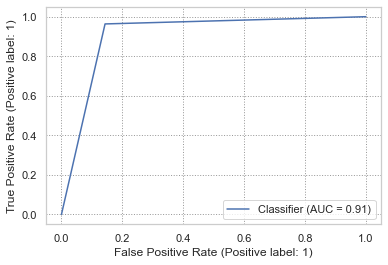

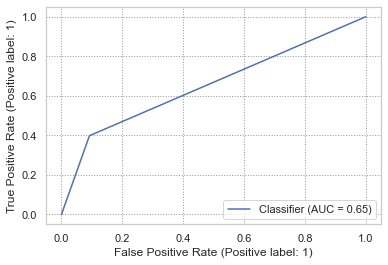

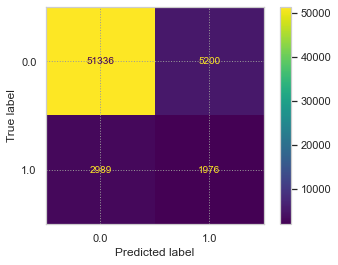

In [15]:
EvalDisplay(model, MyScore)
saveModel(model, 'lgbm')

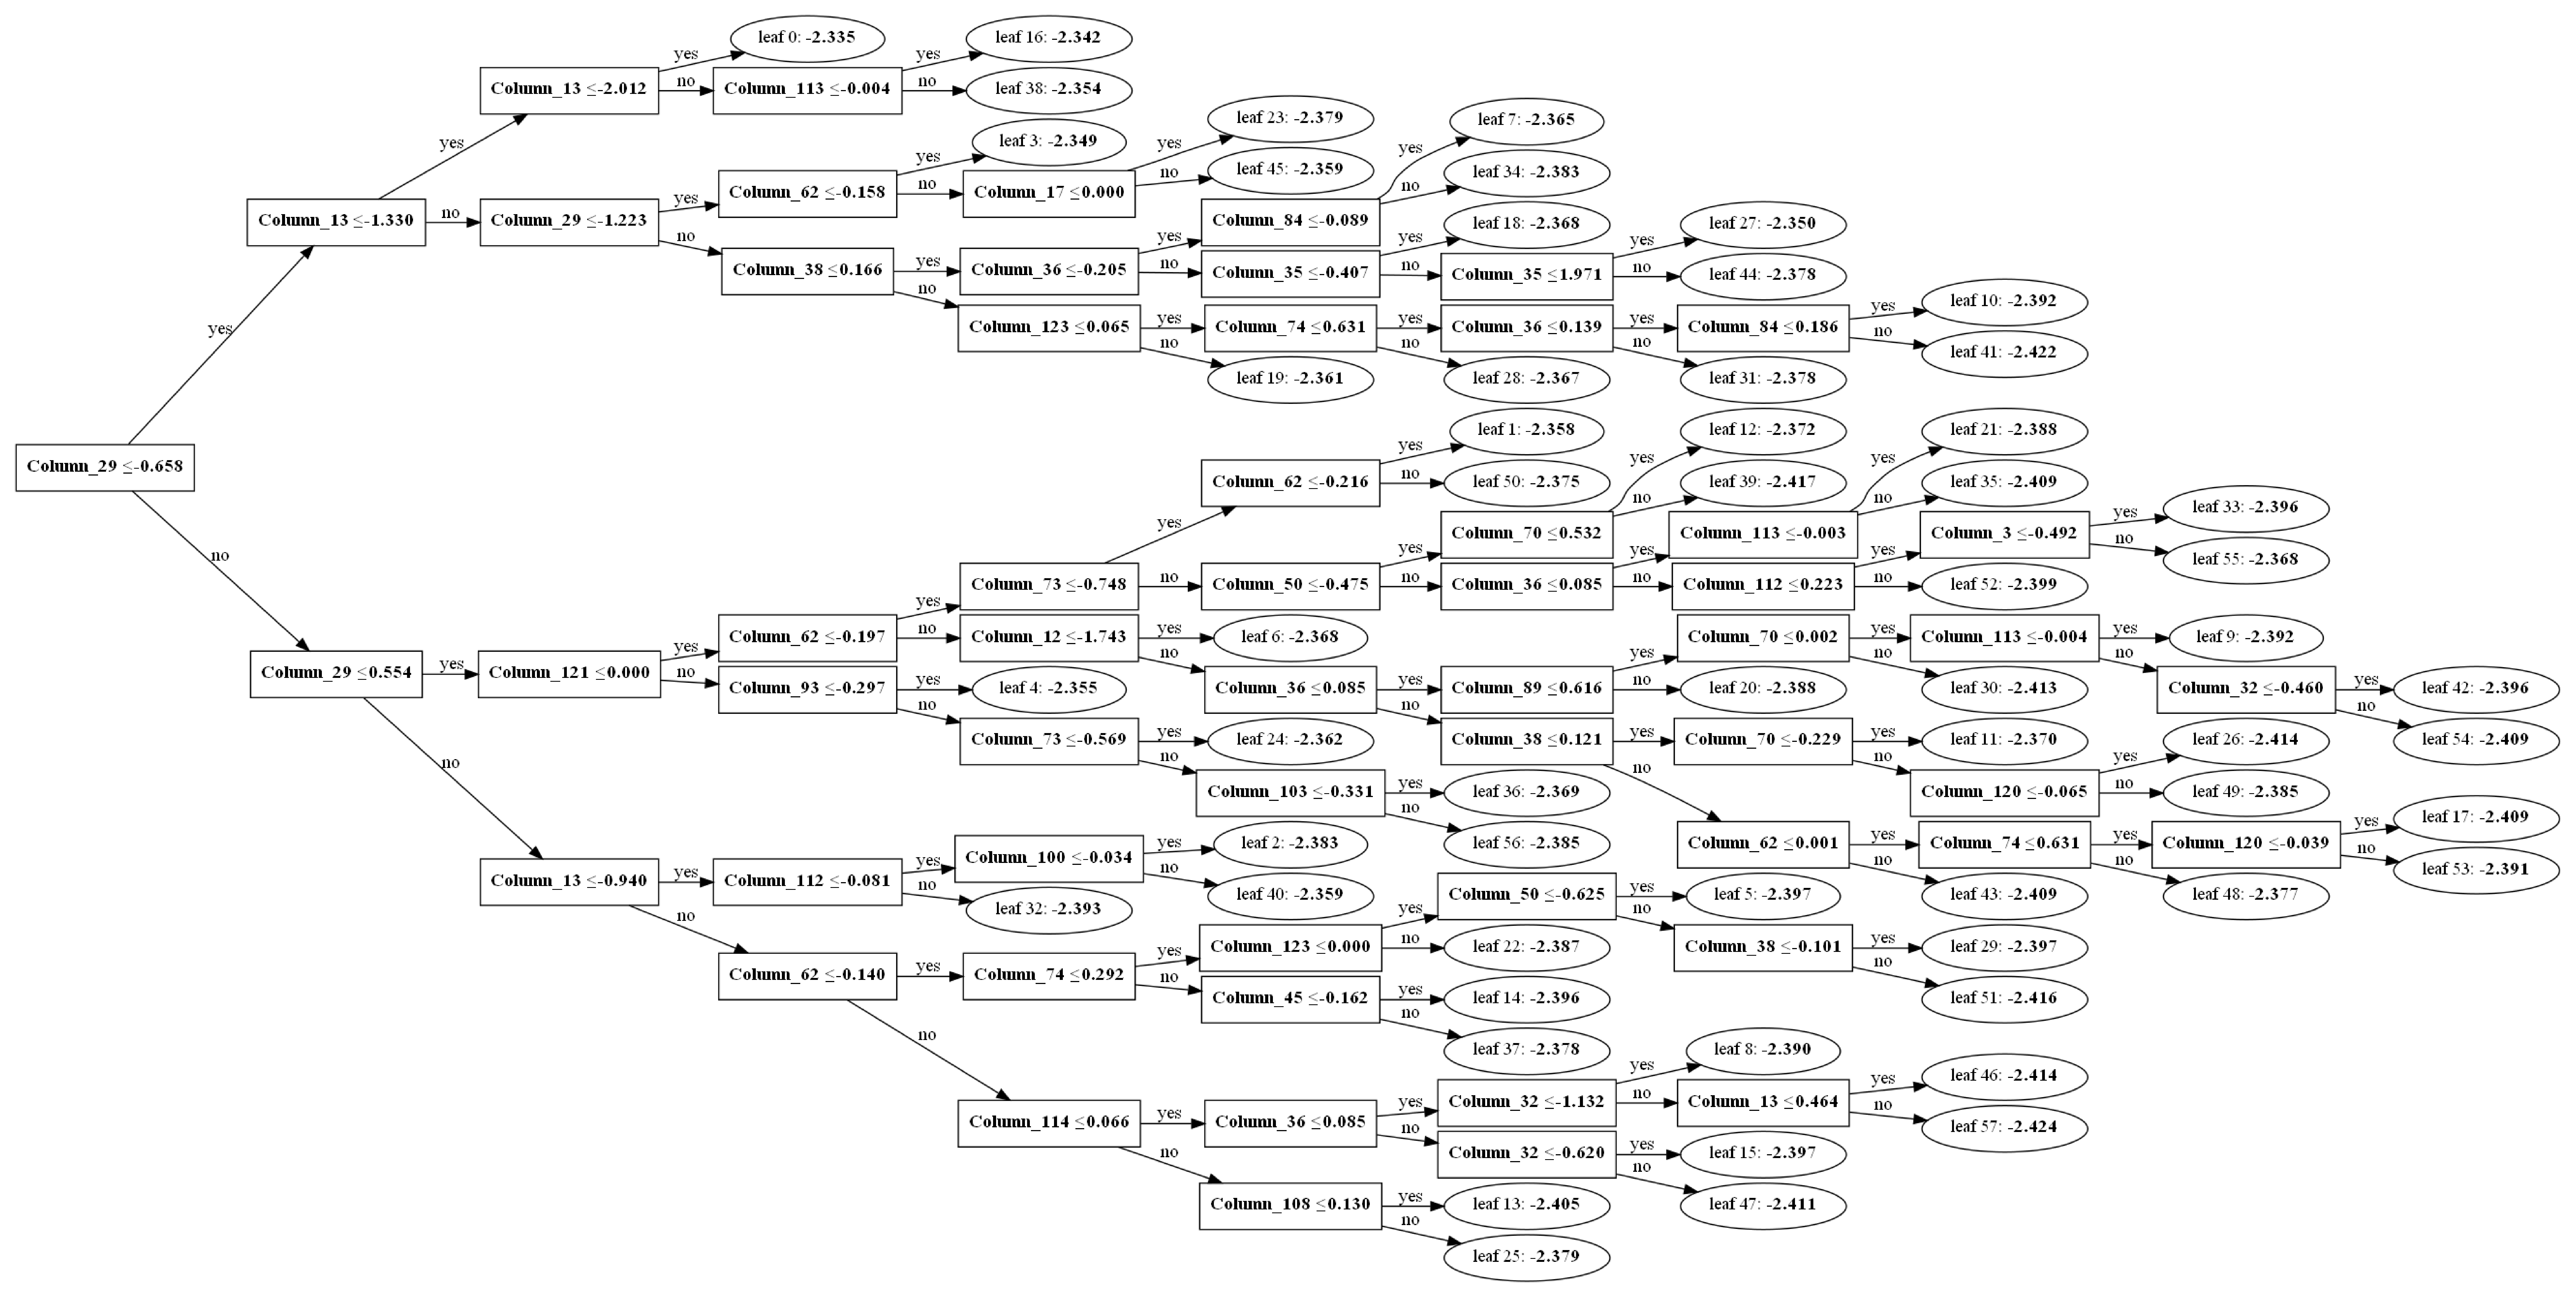

In [16]:
_= plot_tree(model, figsize=(30,40), dpi=400)

#### LGBM & HyperOPT

In [17]:
best_params_bis = {}
best_score_bis = 0

# define the function we want to minimise
def MyModel(params):  
  model = LGBMClassifier(
                              device='gpu',
                              scale_pos_weight=params['scale_pos_weight'],
                              n_estimators=params['n_estimators'],
                              learning_rate=params['learning_rate'],
                              max_depth=params['max_depth'],
                              num_leaves=params['num_leaves'],
                              colsample_bytree =params['colsample_bytree '],
                              subsample=params['subsample'],
                              max_bin=params['max_bin'],
                              reg_alpha=params['reg_alpha'],
                              reg_lambda=params['reg_lambda'],
                              min_child_weight=params['min_child_weight'],
                              min_child_samples=params['min_child_samples'],                              
                              random_state=0, verbose=-1, n_jobs=-1) 
  return model  

def objective(params):
  global best_params_bis
  global best_score_bis

  model = MyModel(params)
  
  skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
  X = x_train
  y = y_train
  skf.get_n_splits(X, y)

  best_score = 0
  for train_index, test_index in skf.split(X, y):
      X_train_skf, X_test_skf = X[train_index], X[test_index]
      y_train_skf, y_test_skf = y[train_index], y[test_index]

      X_res, y_res = SMOTETomek(sampling_strategy=params['sampling_strategy'], smote=SMOTE(k_neighbors=20, n_jobs=-1), random_state=0, n_jobs=-1).fit_resample(X_train_skf, y_train_skf)
      X_val, y_val = SMOTETomek(sampling_strategy=params['sampling_strategy'], smote=SMOTE(k_neighbors=20, n_jobs=-1), random_state=0, n_jobs=-1).fit_resample(X_test_skf, y_test_skf)

      try:
        model.fit(X_res, y_res, eval_set=[(X_res, y_res),(X_val, y_val)], eval_metric=lgbm_metric,  callbacks=[early_stopping(stopping_rounds=5, min_delta=0.001)])

        y_pred = model.predict(x_test)
        score = MyScore(y_test, y_pred)

        if score > best_score:
          best_score = score
        if score > best_score_bis:
          best_score_bis = score
          best_params_bis = params
      except:
        pass
  return {'loss': -best_score, 'status': STATUS_OK}

search_space  = dict([
                    ('scale_pos_weight', hp.uniform('scale_pos_weight', 0., 1.)),
                    ('sampling_strategy', hp.uniform('sampling_strategy', 0.1, 1.)),
                    ('n_estimators', hp.randint('n_estimators', 200, 2000)),
                    ('learning_rate', hp.loguniform('learning_rate', 
                                                     np.log(0.01), np.log(0.5))),
                    ('max_depth', hp.choice('max_depth', range(1, 30, 1))),
                    ('num_leaves', hp.choice('num_leaves', range(2, 100, 1))),
                    ('max_bin', hp.choice('max_bin', range(50, 200, 5))),
                    ('reg_alpha', hp.loguniform('reg_alpha', 
                                                     np.log(0.1), np.log(10.))),
                    ('reg_lambda', hp.loguniform('reg_lambda', 
                                                     np.log(0.1), np.log(10.))),
                    ('min_child_weight', hp.loguniform('min_child_weight', 
                                                     np.log(0.001), np.log(10.))),
                    ('num_leaves', hp.choice('num_leaves', range(2, 100, 1))),
                    ('colsample_bytree ', hp.uniform('colsample_bytree ', 0.1, 1.0)),
                    ('subsample', hp.uniform('subsample', 0.1, 1.0)),
                    ('min_child_samples', hp.choice('min_child_samples', range(10, 1000, 10))),
                    ])
                    
# set the hyperparam tuning algorithm
algorithm=tpe.suggest

In [18]:
# best_params = fmin(
#   fn=objective,
#   space=search_space,
#   algo=algorithm,
#   max_evals=20*1)

# print(best_params)

In [19]:
# lgbm = MyModel(best_params)

# X_res, y_res = SMOTETomek(sampling_strategy=best_params['sampling_strategy'], smote=SMOTE(k_neighbors=20, n_jobs=-1), random_state=0, n_jobs=-1).fit_resample(x_train, y_train)
# X_val, y_val = SMOTETomek(sampling_strategy=best_params['sampling_strategy'], smote=SMOTE(k_neighbors=20, n_jobs=-1), random_state=0, n_jobs=-1).fit_resample(x_test, y_test)
# lgbm.fit(X_res, y_res, eval_set=[(X_res, y_res),(X_val, y_val)], eval_metric=lgbm_metric,  callbacks=[early_stopping(stopping_rounds=5, min_delta=0.001)])

# EvalDisplay(lgbm, roc_auc_score)
# saveModel(lgbm, 'lgbmh')

### Custom Metric

In [55]:
def custom_metric(y, y_pred, **kwargs):
        cm = confusion_matrix(y, y_pred)
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        tp = cm[1, 1]

        n = tn/(tn+fn+1)
        prec = tp/(tp+fp+1)
        
        return (3*n*prec)/(2*n+prec)

custom_scorer = make_scorer(custom_metric)

In [56]:
def MyScore(y_test, y_pred):
  return custom_metric(y_test, y_pred)

#### Baseline

Socre: 0.6091301309979202


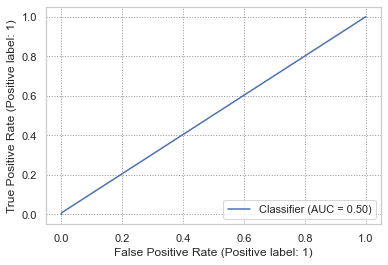

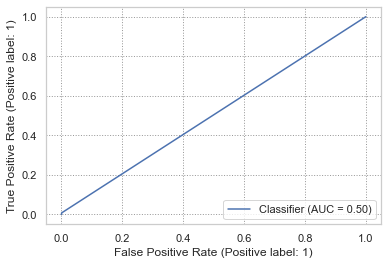

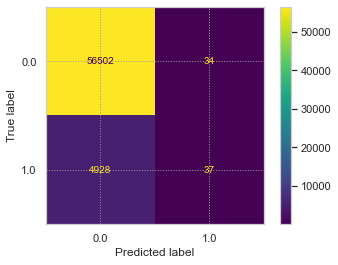

In [23]:
clf = baseline(custom_metric)
EvalDisplay(clf, custom_metric)
saveModel(clf, 'baseline_custom')

#### LGBM

In [59]:
def lgbm_metric(y, preds, threshold=0.5):   
    # display(preds)
    if threshold==None:
        threshold=0.5
    # print('>>>>>>>>>>>>>>>', threshold)
    preds = (preds > threshold).astype(int)
    # # eval_name, eval_result, is_higher_better
    return 'custom_metric', MyScore(y, preds), True

In [49]:
pickle_in = open("lgbm.pkl", "rb")
classifier = pickle.load(pickle_in)

In [51]:
list(classifier.predict_proba(x_test))

[array([0.86972127, 0.13027873]),
 array([0.8536215, 0.1463785]),
 array([0.82187208, 0.17812792]),
 array([0.74908024, 0.25091976]),
 array([0.67489917, 0.32510083]),
 array([0.98492274, 0.01507726]),
 array([0.8746981, 0.1253019]),
 array([0.70294243, 0.29705757]),
 array([0.88037514, 0.11962486]),
 array([0.92618473, 0.07381527]),
 array([0.70168563, 0.29831437]),
 array([0.96354059, 0.03645941]),
 array([0.82460497, 0.17539503]),
 array([0.87971893, 0.12028107]),
 array([0.45651138, 0.54348862]),
 array([0.94781671, 0.05218329]),
 array([0.30538408, 0.69461592]),
 array([0.90429189, 0.09570811]),
 array([0.88159892, 0.11840108]),
 array([0.23154422, 0.76845578]),
 array([0.17206979, 0.82793021]),
 array([0.68074906, 0.31925094]),
 array([0.9053538, 0.0946462]),
 array([0.41840874, 0.58159126]),
 array([0.77836333, 0.22163667]),
 array([0.48860747, 0.51139253]),
 array([0.85343874, 0.14656126]),
 array([0.93392244, 0.06607756]),
 array([0.33151118, 0.66848882]),
 array([0.87607235, 

In [60]:
model = LGBMClassifier(
                            device_type='gpu',
                            scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),                            
                            random_state=0, verbose=2, n_jobs=-1,
                            n_estimators=5000,
                            learning_rate=0.01,
                            max_depth=11,
                            num_leaves=58,
                            colsample_bytree=0.613,
                            subsample=0.708,
                            max_bin=63,
                            reg_alpha=3.564,
                            reg_lambda=4.930,
                            min_child_weight=6,
                            min_child_samples=165,                            
                            )
model = model.fit(x_train, y_train, eval_set=[(x_train, y_train) ,(x_test, y_test)], eval_metric=lgbm_metric)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226144
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.822625
[LightGBM] [Info] Total Bins 6738
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 124
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 109 dense feature groups (26.28 MB) transferred to GPU in 0.021558 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432464
[LightGBM] [Info] Start training from score -2.432464
[LightGBM] [Debug] Trained a tree with leaves = 58 and depth = 10
[1]	training's binary_logloss: 0.279188	training's custom_metric: 0	valid_1's binary_logloss: 0.279355	valid_1's custo

Socre: 0.36176434757776604


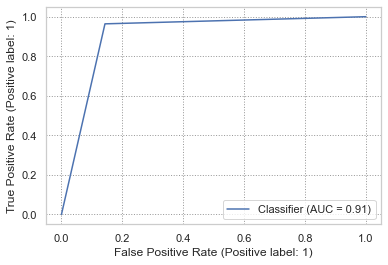

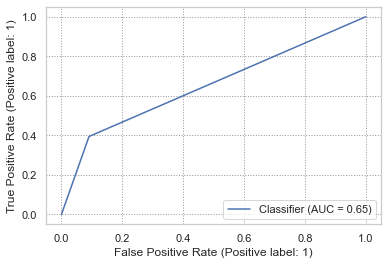

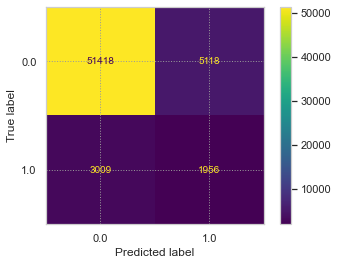

In [61]:
EvalDisplay(model, MyScore)
saveModel(model, 'lgbmc')

In [ ]:
0/0

#### LGBM & HyperOPT

In [ ]:
best_params = fmin(
  fn=objective,
  space=search_space,
  algo=algorithm,
  max_evals=20*2)

print(best_params)

  2%|▏         | 2/100 [02:44<2:13:03, 81.47s/trial, best loss: -0.8972975176016276]

invalid value encountered in longlong_scalars



  7%|▋         | 7/100 [07:48<1:46:54, 68.98s/trial, best loss: -0.8972975176016276]

invalid value encountered in longlong_scalars



 11%|█         | 11/100 [14:24<1:58:53, 80.15s/trial, best loss: -0.8972975176016276] 

invalid value encountered in longlong_scalars



 21%|██        | 21/100 [31:31<1:42:29, 77.84s/trial, best loss: -0.8972975176016276] 

invalid value encountered in longlong_scalars



 29%|██▉       | 29/100 [43:18<1:12:31, 61.28s/trial, best loss: -0.9586501176829165] 

invalid value encountered in longlong_scalars



 30%|███       | 30/100 [43:57<1:03:38, 54.56s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 31%|███       | 31/100 [44:23<52:54, 46.01s/trial, best loss: -0.9586501176829165]  

invalid value encountered in longlong_scalars



 32%|███▏      | 32/100 [45:02<49:48, 43.95s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 33%|███▎      | 33/100 [47:07<1:15:58, 68.03s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 34%|███▍      | 34/100 [48:09<1:13:00, 66.37s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 35%|███▌      | 35/100 [49:13<1:11:14, 65.77s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 36%|███▌      | 36/100 [50:08<1:06:37, 62.46s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 37%|███▋      | 37/100 [50:46<57:54, 55.15s/trial, best loss: -0.9586501176829165]  

invalid value encountered in longlong_scalars



 38%|███▊      | 38/100 [52:35<1:13:34, 71.20s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 39%|███▉      | 39/100 [53:40<1:10:32, 69.38s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 40%|████      | 40/100 [56:28<1:38:50, 98.84s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 41%|████      | 41/100 [57:01<1:17:52, 79.20s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 42%|████▏     | 42/100 [58:39<1:22:00, 84.83s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 43%|████▎     | 43/100 [1:00:32<1:28:33, 93.22s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 44%|████▍     | 44/100 [1:01:13<1:12:21, 77.52s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 45%|████▌     | 45/100 [1:02:27<1:10:07, 76.51s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 46%|████▌     | 46/100 [1:02:54<55:34, 61.76s/trial, best loss: -0.9586501176829165]  

invalid value encountered in longlong_scalars



 47%|████▋     | 47/100 [1:04:21<1:01:16, 69.38s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 48%|████▊     | 48/100 [1:05:17<56:29, 65.18s/trial, best loss: -0.9586501176829165]  

invalid value encountered in longlong_scalars



 49%|████▉     | 49/100 [1:06:07<51:41, 60.81s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 50%|█████     | 50/100 [1:08:26<1:10:06, 84.14s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 52%|█████▏    | 52/100 [1:10:52<1:03:47, 79.74s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 54%|█████▍    | 54/100 [1:12:39<51:38, 67.37s/trial, best loss: -0.9586501176829165]  

invalid value encountered in longlong_scalars



 56%|█████▌    | 56/100 [1:14:20<41:27, 56.53s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 57%|█████▋    | 57/100 [1:15:21<41:18, 57.64s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 58%|█████▊    | 58/100 [1:15:56<35:44, 51.07s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 59%|█████▉    | 59/100 [1:16:19<29:02, 42.50s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 61%|██████    | 61/100 [1:18:11<32:21, 49.78s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 63%|██████▎   | 63/100 [1:20:27<34:16, 55.58s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 64%|██████▍   | 64/100 [1:21:12<31:29, 52.49s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 65%|██████▌   | 65/100 [1:21:53<28:36, 49.03s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 66%|██████▌   | 66/100 [1:23:16<33:26, 59.02s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 67%|██████▋   | 67/100 [1:23:43<27:17, 49.63s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 68%|██████▊   | 68/100 [1:24:11<23:02, 43.19s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 69%|██████▉   | 69/100 [1:25:10<24:46, 47.96s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 70%|███████   | 70/100 [1:25:42<21:31, 43.05s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 71%|███████   | 71/100 [1:27:41<31:48, 65.80s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 72%|███████▏  | 72/100 [1:28:06<25:03, 53.68s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 73%|███████▎  | 73/100 [1:29:02<24:26, 54.31s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 74%|███████▍  | 74/100 [1:29:34<20:36, 47.55s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 75%|███████▌  | 75/100 [1:29:54<16:24, 39.38s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 76%|███████▌  | 76/100 [1:30:54<18:15, 45.64s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 77%|███████▋  | 77/100 [1:31:31<16:26, 42.87s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 78%|███████▊  | 78/100 [1:31:53<13:28, 36.74s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 79%|███████▉  | 79/100 [1:32:17<11:27, 32.74s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 80%|████████  | 80/100 [1:32:41<10:04, 30.21s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 81%|████████  | 81/100 [1:32:58<08:15, 26.10s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 82%|████████▏ | 82/100 [1:33:33<08:41, 28.95s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 83%|████████▎ | 83/100 [1:34:45<11:51, 41.84s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 84%|████████▍ | 84/100 [1:35:15<10:10, 38.16s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 85%|████████▌ | 85/100 [1:35:44<08:51, 35.45s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 86%|████████▌ | 86/100 [1:36:08<07:28, 32.03s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 87%|████████▋ | 87/100 [1:36:34<06:34, 30.38s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 88%|████████▊ | 88/100 [1:37:10<06:24, 32.08s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 89%|████████▉ | 89/100 [1:38:58<10:01, 54.72s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 90%|█████████ | 90/100 [1:39:33<08:07, 48.72s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 91%|█████████ | 91/100 [1:40:30<07:42, 51.42s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 92%|█████████▏| 92/100 [1:41:31<07:14, 54.26s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 93%|█████████▎| 93/100 [1:42:01<05:27, 46.78s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 94%|█████████▍| 94/100 [1:42:28<04:05, 40.85s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 95%|█████████▌| 95/100 [1:42:51<02:57, 35.49s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 96%|█████████▌| 96/100 [1:43:39<02:37, 39.47s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 97%|█████████▋| 97/100 [1:44:28<02:06, 42.10s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 98%|█████████▊| 98/100 [1:45:12<01:25, 42.70s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



 99%|█████████▉| 99/100 [1:45:32<00:36, 36.12s/trial, best loss: -0.9586501176829165]

invalid value encountered in longlong_scalars



100%|██████████| 100/100 [1:45:59<00:00, 63.60s/trial, best loss: -0.9586501176829165]
{'colsample_bytree ': 0.11510026083564001, 'learning_rate': 0.010922929112342258, 'max_bin': 24, 'max_depth': 7, 'min_child_samples': 7, 'min_child_weight': 0.24019737681121675, 'n_estimators': 1167, 'num_leaves': 73, 'reg_alpha': 9.834269953639668, 'reg_lambda': 0.259225232476161, 'scale_pos_weight': 0.45828090139937183, 'subsample': 0.9087622265172626}


invalid value encountered in longlong_scalars



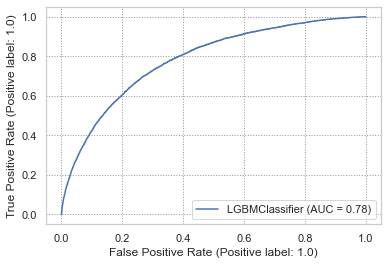

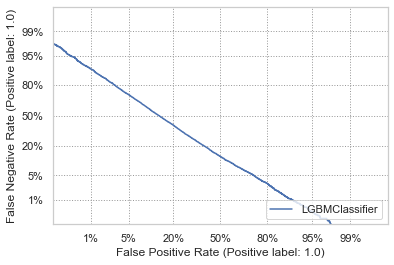

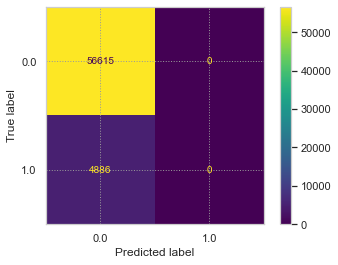

In [ ]:
lgbmc = MyModel(best_params)
X_res, y_res = SMOTETomek(sampling_strategy=best_params['sampling_strategy'], smote=SMOTE(k_neighbors=20, n_jobs=-1), random_state=0, n_jobs=-1).fit_resample(x_train, y_train)
X_val, y_val = SMOTETomek(sampling_strategy=best_params['sampling_strategy'], smote=SMOTE(k_neighbors=20, n_jobs=-1), random_state=0, n_jobs=-1).fit_resample(x_test, y_test)
lgbm.fit(X_res, y_res, eval_set=[(X_res, y_res),(X_val, y_val)], eval_metric=lgbm_metric,  callbacks=[early_stopping(stopping_rounds=5, min_delta=0.001)])

EvalDisplay(lgbmc, custom_metric)
saveModel(lgbmc, 'lgbmhc')

## Feature Importance</a>

### With Random forest

In [ ]:
rf = RandomForestClassifier(n_estimators=50, max_depth=8, min_samples_leaf=4, max_features=0.5, random_state=2018)
rf.fit(df.drop(columns=['TARGET']), df.TARGET)
features = df.drop(columns=['TARGET']).columns.values

In [ ]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ),
    margin=dict(
    l=300,
),
)

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

### With SHAP

-------------- Class 0  --------------


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


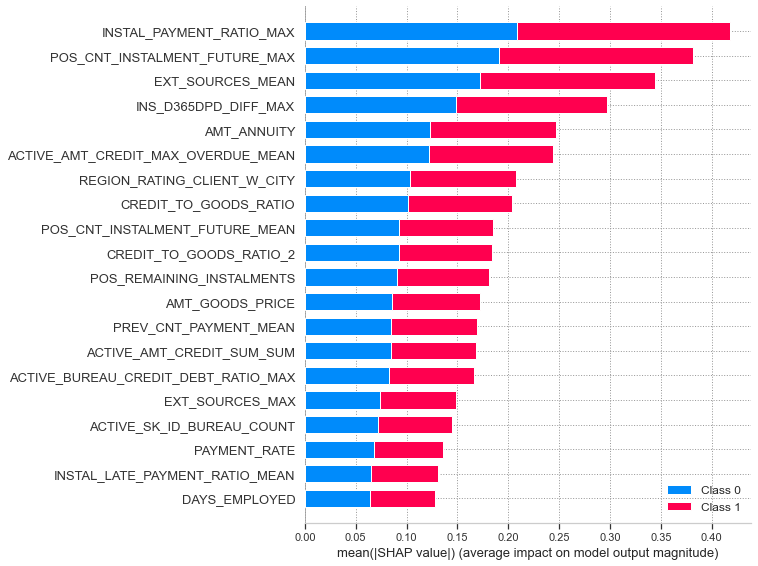

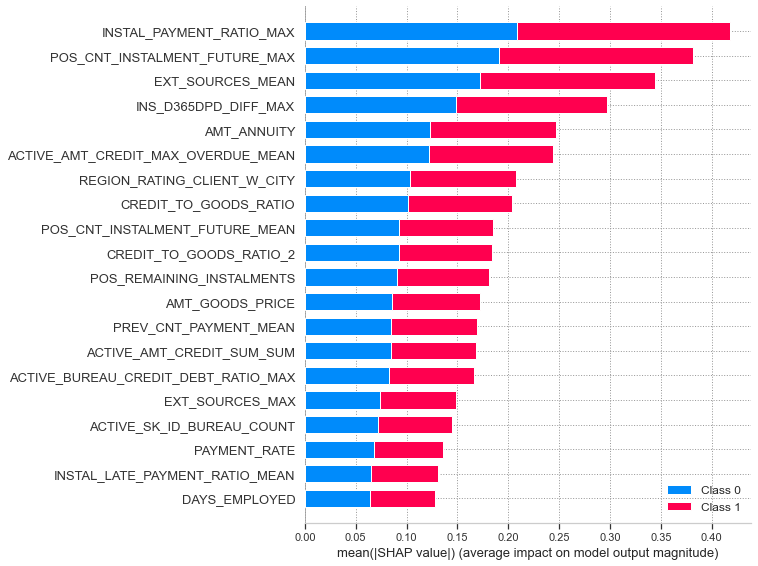

-------------- Class 1  --------------


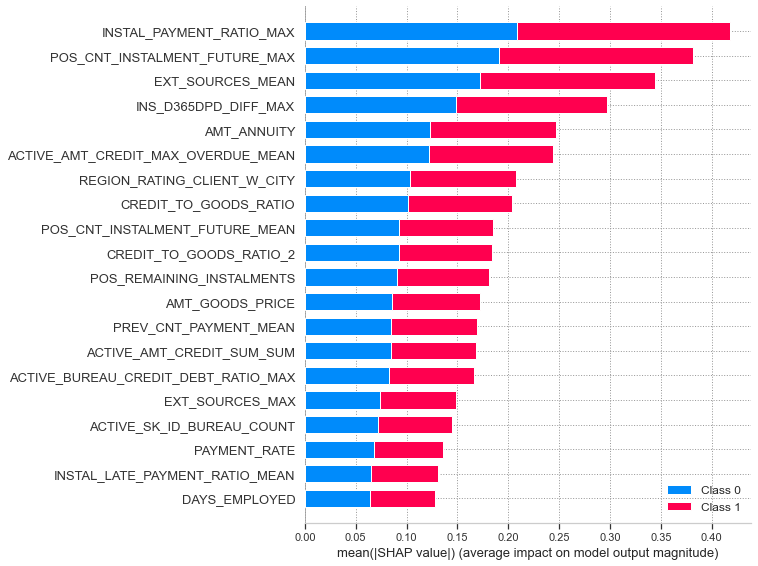

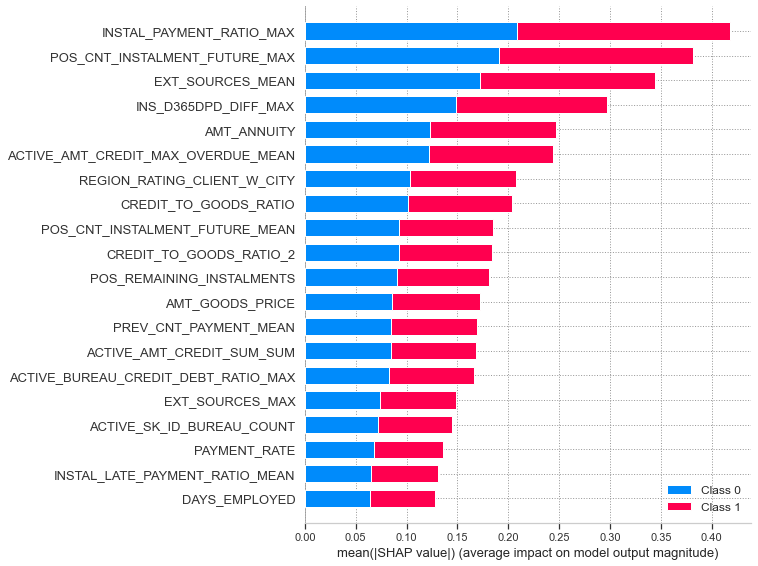

In [ ]:
X=df.drop(columns=['TARGET'])
#Importance des attributs avec les SHAP values
for i in range(2):
    print('-------------- Class', str(i), ' --------------')
    explainer = shap.TreeExplainer(lgbmc)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, plot_type="bar")
    shap.summary_plot(shap_values, X)